In [7]:
import numpy as np
import pandas as pd
import glob
from sklearn import linear_model, metrics
import scipy.optimize
import random
from math import exp
from math import log
import random
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv('data/train.csv', index_col=None, header=0)
df_test = pd.read_csv('data/test.csv', index_col=None, header=0)

In [5]:
### HOT ENCODING ###
for i in range(0,9):
    if i==7:
        continue
    featureName = 'X'+str(i)
    for c in df[featureName].unique():
        df[featureName+c] = np.where(df[featureName]==c, 1, 0)
    #df = df.drop(featureName,1)

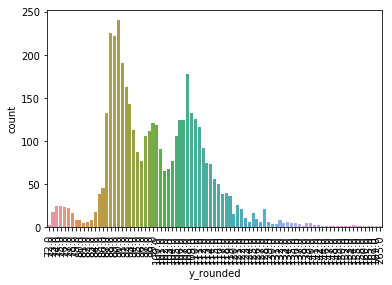

In [12]:
### Plot for the distribution of y ###
plt.cla()
df['y_rounded'] = df['y'].astype(int)/1000
df['y_rounded'] = df['y_rounded']*1000
y_dist = sns.countplot(x='y_rounded',data=df)
for item in y_dist.get_xticklabels():
    item.set_rotation(90)
plt.show()

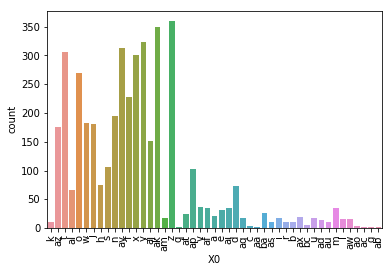

In [13]:
### Plot for the 
plt.cla()
index = ['X0','X1','X2','X3','X3','X4','X5','X6','X8']
x_category = sns.countplot(x=index[0],data=df)
for item in x_category.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [14]:
df = pd.read_csv('data/train.csv', index_col=None, header=0)
df_test = pd.read_csv('data/test.csv', index_col=None, header=0)

usable_columns = list(set(df.columns)-set(['ID', 'y']))
y_train = df['y'].values
id_test = df_test['ID'].values

x_train = df[usable_columns]
x_test = df_test[usable_columns]

# Now drop all constant features
for col in usable_columns:
    card = len(np.unique(x_train[col]))
    if card == 1:
        x_train.drop(col, axis=1)
        x_test.drop(col,axis=1)
    if card > 2:
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[col] = x_train[col].apply(mapper)
        x_test[col] = x_test[col].apply(mapper)

x_train.head()

/Users/thomasan/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/thomasan/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,X189,X185,X184,X187,X186,X181,X180,X183,X182,X291,...,X96,X97,X98,X99,X204,X205,X202,X203,X200,X201
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


In [17]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1313)


# Distribution of Feature Importance
Get distribution of feature importance using random trees

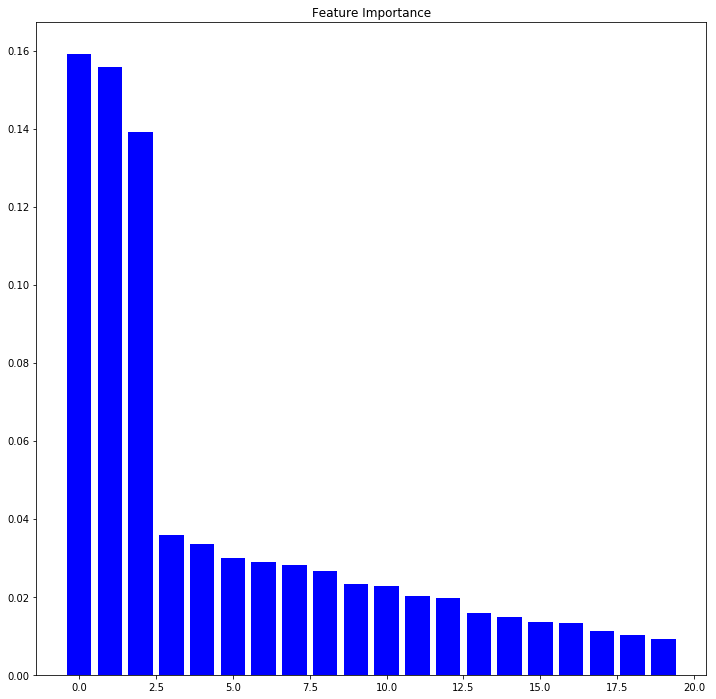

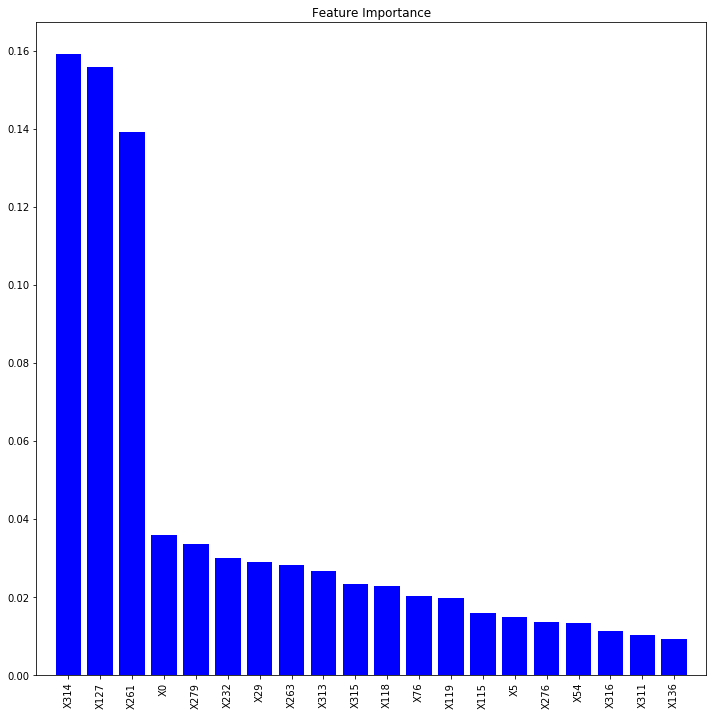

In [21]:
from sklearn import ensemble

model = ensemble.RandomForestRegressor(n_estimators=200,
                                      max_depth=10,
                                      min_samples_leaf=4,
                                      max_features=0.2,
                                      n_jobs=-1,
                                      random_state=0)
model.fit(x_train, y_train)
feat_names = X_train.columns.values

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature Importance")
plt.bar(range(len(indices)), importances[indices], color="b", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation="vertical")
plt.xlim([-1, len(indices)])
plt.show()



In [ ]:
# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=Y_train)
dval = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test)

def get_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)


params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.03
params['max_depth'] = 4

training = xgb.train(params, dtrain, 1000, [(dtrain, 'train'), (dval, 'valid')],
                    early_stopping_rounds=50, feval=get_score, maximize=True,
                     verbose_eval=10)